In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
# Importa la función para crear la matriz de confusión
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#cr_cp = pm.df('cr_cp')
#fe_cp = pm.df('fe_cp')
df_jo = pm.df('df_jo')
#df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
#df_jo = df_jo.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
#df_jo_cp = df_jo.copy()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])
#df_jo.info()

,n_backs,n_fees,n_inc_fees,n_cr_fe_w,transfer_type_regular
0,0,0,0,NaN,1


,n_backs,n_fees,n_inc_fees,n_cr_fe_w,transfer_type_regular
0,-1.047367,-0.868485,-0.499281,0.000000,1.243453
1,-0.329742,-0.868485,-0.499281,-0.552189,1.243453


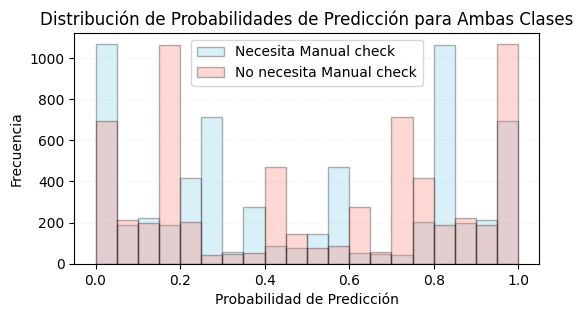

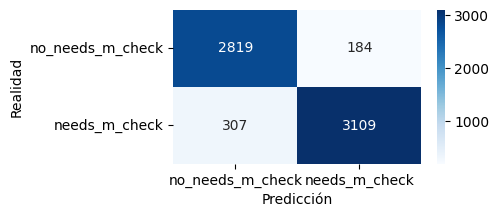

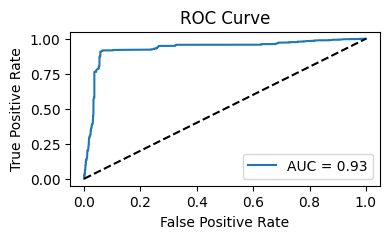

Accuracy: 0.9235083346315626
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      3003
           1       0.94      0.91      0.93      3416

    accuracy                           0.92      6419
   macro avg       0.92      0.92      0.92      6419
weighted avg       0.92      0.92      0.92      6419

Coeficientes del modelo de regresión logística (ordenados por magnitud):
n_inc_fees: 4.1641
n_fees: -1.6251
n_backs: -1.2341
n_cr_fe_w: 0.8906
transfer_type_regular: -0.1450
predicciones_probabilidades:
 [[8.07734436e-01 1.92265564e-01]
 [3.55573803e-02 9.64442620e-01]
 [2.46624472e-01 7.53375528e-01]
 [9.96068636e-01 3.93136389e-03]
 [9.24201775e-05 9.99907580e-01]
 [4.78374624e-01 5.21625376e-01]
 [5.13166941e-01 4.86833059e-01]
 [4.54276601e-01 5.45723399e-01]
 [2.00265754e-01 7.99734246e-01]
 [4.83016346e-01 5.16983654e-01]]



In [80]:
df = df_jo.copy()
# Convertir columnas datetime a timestamps
for col in df.select_dtypes(include=['datetime64']).columns:
    df[col] = df[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)

for col in df.select_dtypes(include=['timedelta64']).columns:
    df[col] = df[col].apply(lambda x: x / pd.to_timedelta(1, unit='d') if pd.notnull(x) else None)

#df['moderada'] = df['moderated_at'].apply(lambda x: 1 if not pd.isnull(x) else 0)

# Variables predictoras (ajusta según los datos disponibles)
#columnas = ['amount','fee','n_backs','n_fees','n_inc_back','n_inc_fees','to_reimbur', 'type', 'transfer_type','category','charge_moment'] #'user_id',   
#columnas = ['n_inc_back','n_inc_fees','n_recovery'] # 
#columnas = ['n_backs','n_fees','n_inc_back','n_inc_fees','n_cr_fe_m'] #
columnas = ['n_backs','n_fees','n_inc_fees','n_cr_fe_w', 'transfer_type'] 
X = df[columnas].copy()

# Categoricas
#X = pd.get_dummies(X, columns=['type', 'transfer_type', 'category','charge_moment'], drop_first=True, dtype =int)
X = pd.get_dummies(X, columns=['transfer_type'], drop_first=True, dtype =int)


# Crear el escalador
display(X.head(1))
scaler = StandardScaler()
# Estandarizar todas las columnas
normalizado = scaler.fit_transform(X)
# Convertir de nuevo a DataFrame, preservando nombres de columnas e índices
X = pd.DataFrame(normalizado, columns=X.columns, index=df.index)
X.fillna(0, inplace=True)
#X.info()


y = df['needs_m_check_recov'].copy()  #moderada # La columna de la variable objetivo
display(X.head(2))

feature_names = X.columns # Obtener los nombres de las características
# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")
clf.fit(X_train, y_train) # Entrena el clasificador
predicciones = clf.predict(X_test) # Realiza predicciones sobre el conjunto de prueba

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(6, 3)) 
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor
plt.figure(figsize=(4, 2))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, predicciones_probabilidades[:, 1])
plt.figure(figsize=(4, 2))
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Evaluate model performance
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report


# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.4f}")

# Muestra las primeras 10 probabilidades de predicción
print(f"predicciones_probabilidades:\n {predicciones_probabilidades[:10]}\n")
